In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Map sensor locations to DataFrame columns
location_to_column = {
    "Left Knee": "leftKneeFlexionAngle",
    "Left Hip": "leftHipFlexionAngle",
    "Left Ankle": "leftAnkleAngle",
    "Right Knee": "rightKneeFlexionAngle",
    "Right Hip": "rightHipFlexionAngle",
    "Right Ankle": "rightAnkleAngle"
}

def process_json_data(json_data):
    angles = {"timestamp": json_data["timestamp"]}
    
    # Extract roll angles from each sensor
    for sensor in json_data["sensors"]:
        location = sensor["location"]
        if location in location_to_column:
            column_name = location_to_column[location]
            angles[column_name] = sensor["euler"]["roll"]
    
    columns_order = [
        'rightKneeFlexionAngle',
        'rightHipFlexionAngle', 
        'rightAnkleAngle',
        'leftKneeFlexionAngle', 
        'leftHipFlexionAngle', 
        'leftAnkleAngle'
    ]
    
    return angles

In [11]:
# Open the JSON file and load each line separately
DATA_DIR = 'data'
JSON_EXT = '.json'

file_paths = [DATA_DIR+"/"+f for f in os.listdir(DATA_DIR) if f[-len(JSON_EXT):] == JSON_EXT]

data = []

for fp in file_paths:
    with open(fp, 'r') as file:
        data.append([json.loads(line.strip()) for line in file if line.strip()])  # Load each JSON object separately


In [12]:
processed_data = [[process_json_data(entry) for entry in dataset] for dataset in data]

# Convert list of dicts to DataFrame
train_data_l = []
test_data_l = []
for pd_dataset in processed_data:
    split_ind = int(len(pd_dataset) * 0.8)
    train_data_l += pd_dataset[:split_ind]
    test_data_l += pd_dataset[split_ind:]

angle_df_train = pd.DataFrame(train_data_l)
angle_df_test = pd.DataFrame(test_data_l)

# Convert timestamp to datetime & sort
angle_df_train["timestamp"] = pd.to_datetime(angle_df_train["timestamp"])
angle_df_train = angle_df_train.set_index("timestamp").sort_index()

angle_df_test["timestamp"] = pd.to_datetime(angle_df_test["timestamp"])
angle_df_test = angle_df_test.set_index("timestamp").sort_index()
# Fill missing values if needed
angle_df_train = angle_df_train.ffill()  # Forward-fill missing values
angle_df_test = angle_df_test.ffill()  # Forward-fill missing values


#This spliting method guarantees the data won't be shuffled
train_data = angle_df_train.iloc[:]
test_data = angle_df_test.iloc[:]

# Normalize using training stats
scaler = StandardScaler()
train_normalized = scaler.fit_transform(train_data)
test_normalized = scaler.transform(test_data)

# Sequence creation function
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Reduced sequence length for better temporal focus
SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_normalized, SEQ_LENGTH)
X_test, y_test = create_sequences(test_normalized, SEQ_LENGTH)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: torch.Size([13365, 30, 6]) torch.Size([13365, 6])
Testing Data Shape: torch.Size([3323, 30, 6]) torch.Size([3323, 6])


In [13]:
class AngleDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

BATCH_SIZE = 64
train_dataset = AngleDataset(X_train, y_train)
test_dataset = AngleDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 6)
        
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

model = ImprovedLSTM().to(device)
print(model)

ImprovedLSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [15]:
LEARNING_RATE = 0.001
EPOCHS = 100

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

Epoch 10/100
Train Loss: 0.2502 | Val Loss: 0.2471
LR: 1.00e-03
--------------------------------------------------
Epoch 20/100
Train Loss: 0.1886 | Val Loss: 0.1924
LR: 1.00e-03
--------------------------------------------------
Epoch 30/100
Train Loss: 0.1525 | Val Loss: 0.1680
LR: 1.00e-03
--------------------------------------------------
Epoch 40/100
Train Loss: 0.1290 | Val Loss: 0.1706
LR: 1.00e-03
--------------------------------------------------
Epoch 50/100
Train Loss: 0.1097 | Val Loss: 0.1631
LR: 5.00e-04
--------------------------------------------------
Epoch 60/100
Train Loss: 0.0838 | Val Loss: 0.1668
LR: 2.50e-04
--------------------------------------------------
Epoch 70/100
Train Loss: 0.0786 | Val Loss: 0.1660
LR: 6.25e-05
--------------------------------------------------
Epoch 80/100
Train Loss: 0.0764 | Val Loss: 0.1657
LR: 1.56e-05
--------------------------------------------------
Epoch 90/100
Train Loss: 0.0761 | Val Loss: 0.1661
LR: 7.81e-06
----------------

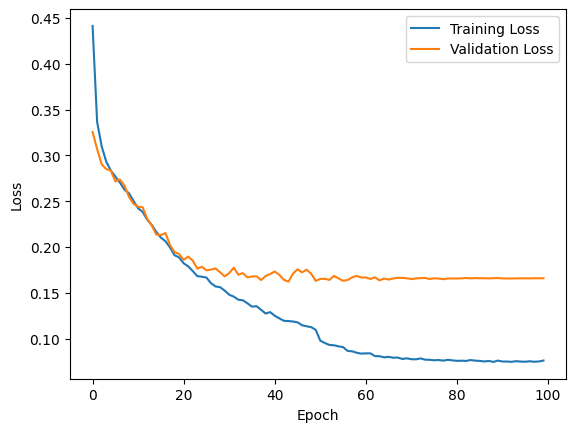

In [16]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_train_loss = 0
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            epoch_val_loss += loss.item()
    
    # Calculate metrics
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(test_loader)
    scheduler.step(avg_val_loss)
    
    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        print('-'*50)

# Plot learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

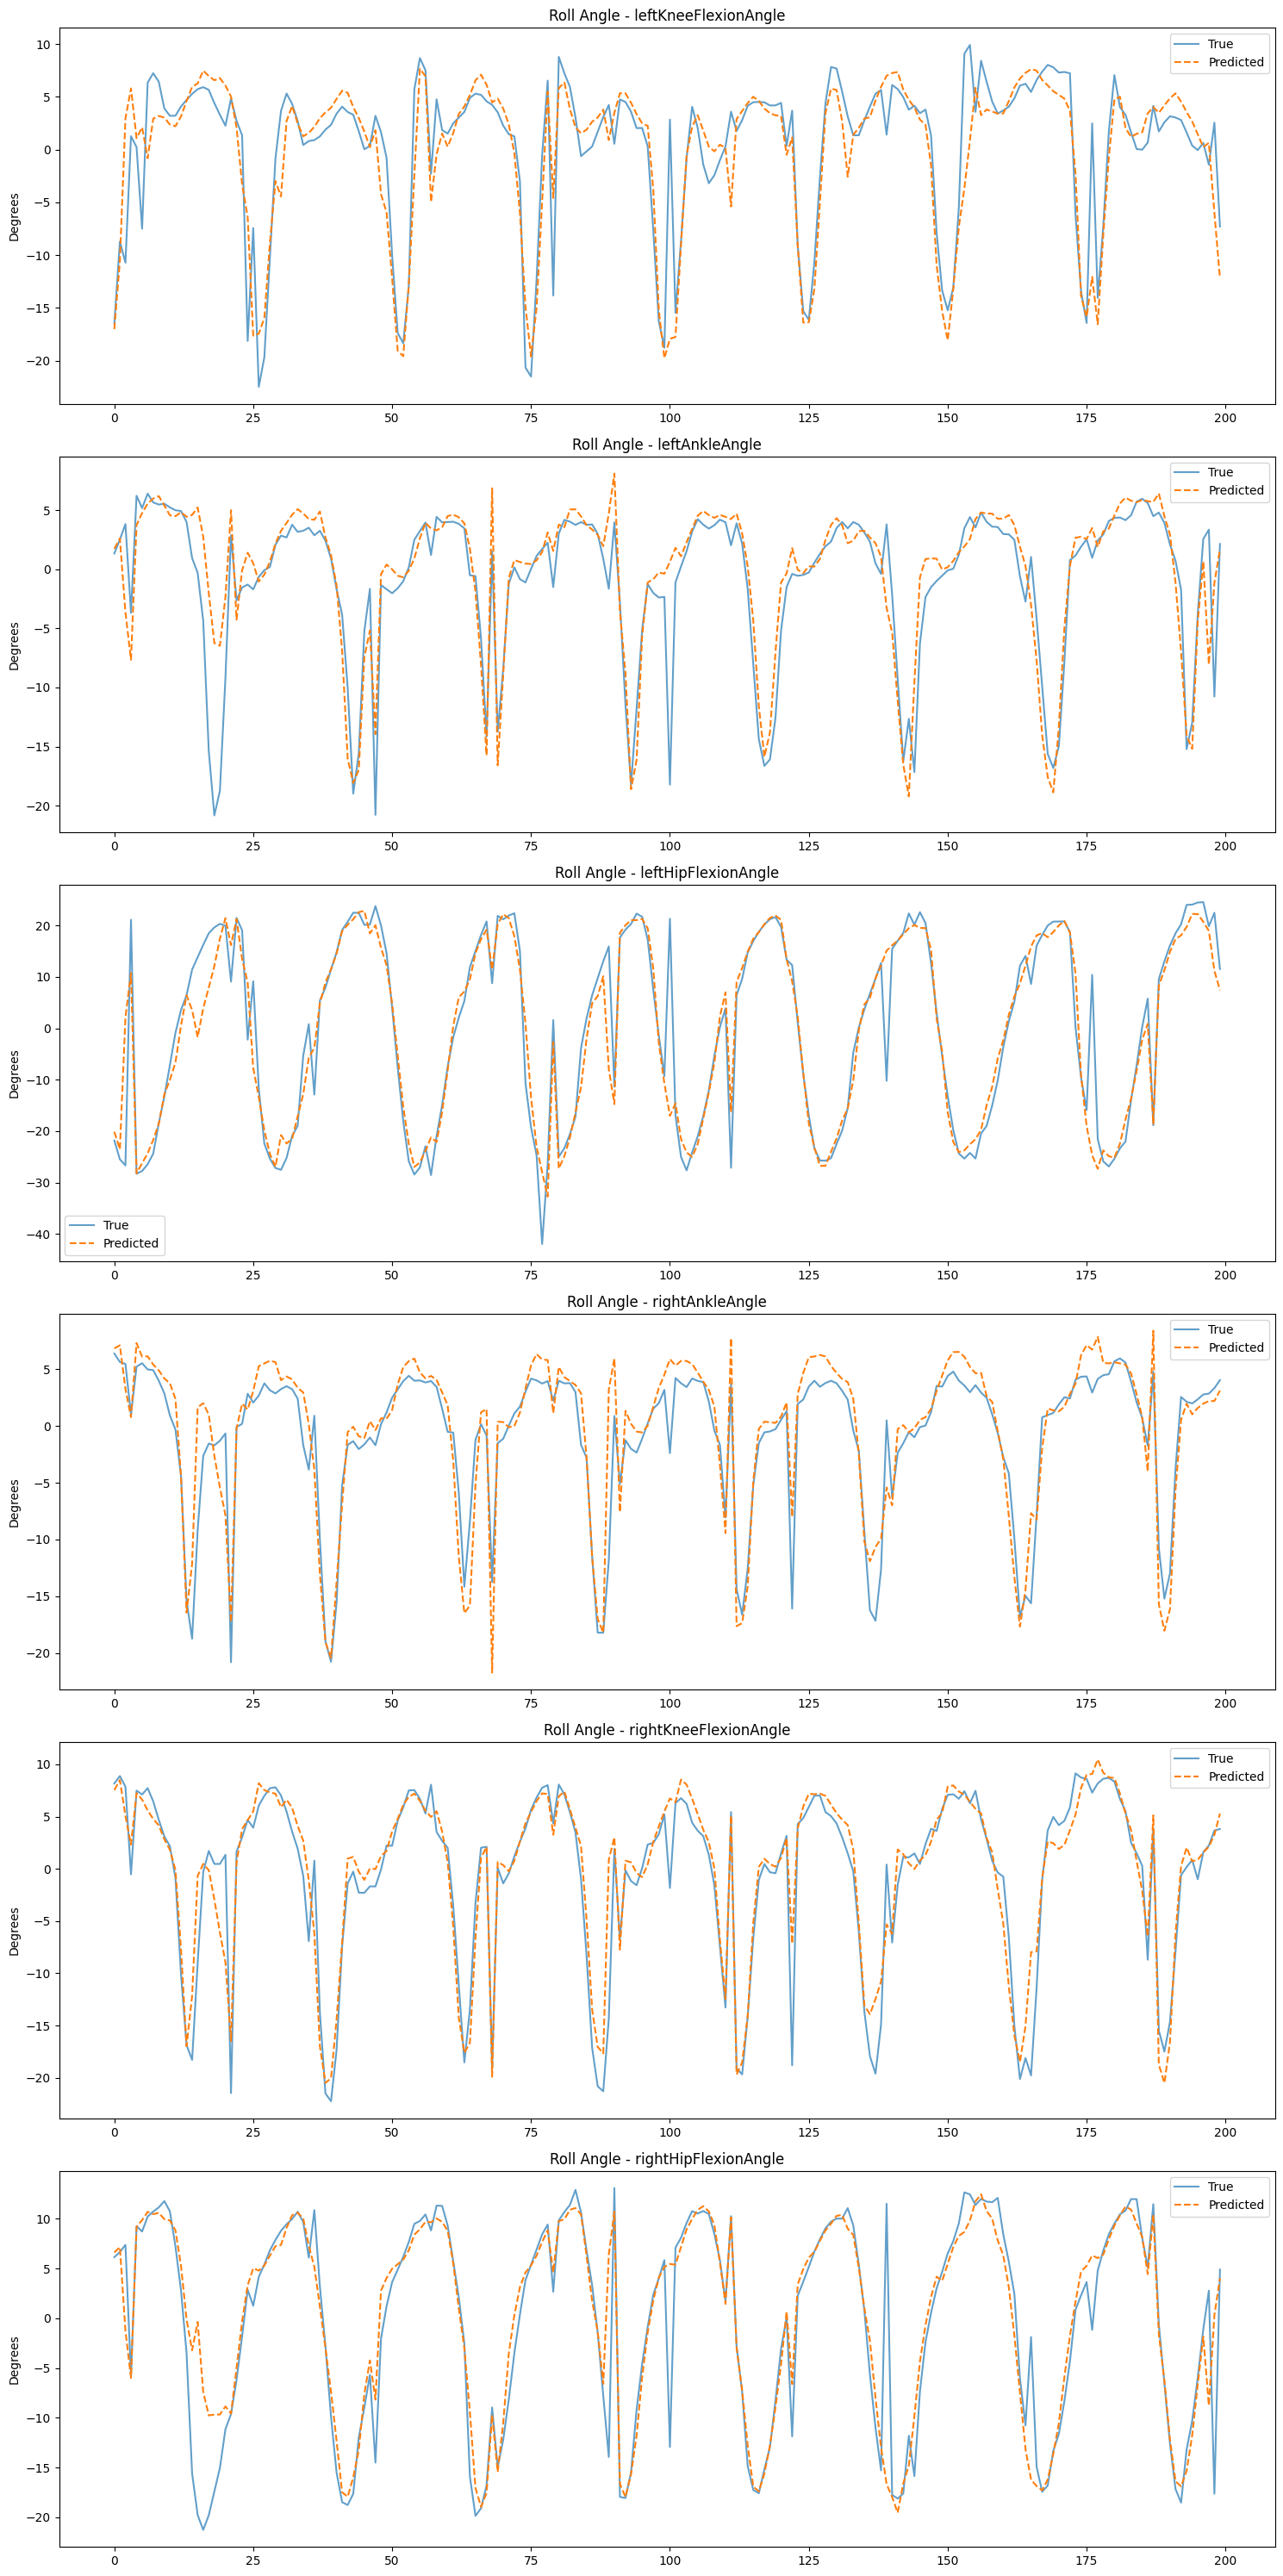

In [21]:
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        pred = model(X).cpu().numpy()
        predictions.append(pred)
        true_values.append(y.numpy())

predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

# Unnormalize data
predictions = scaler.inverse_transform(predictions)
true_values = scaler.inverse_transform(true_values)

# # Identify roll angle columns
# roll_columns = [col for col in angle_df.columns if "roll" in col.lower()]
# roll_indices = [angle_df.columns.get_loc(col) for col in roll_columns]

# Identify flexion angle columns (since there are no roll angles)
roll_columns = [col for col in angle_df.columns if "Angle" in col]  # This selects all the angle columns
roll_indices = [angle_df.columns.get_loc(col) for col in roll_columns]


# Extract roll angles after inverse transform
predictions_roll = predictions[:, roll_indices]
true_values_roll = true_values[:, roll_indices]

# Plot roll angles only
plt.figure(figsize=(15, 5 * len(roll_indices)))
for i, (idx, col_name) in enumerate(zip(roll_indices, roll_columns)):
    plt.subplot(len(roll_indices), 1, i+1)
    location = col_name.split('_')[0]  # Extract location from column name
    plt.plot(true_values[:200, idx], label='True', alpha=0.7)
    plt.plot(predictions[:200, idx], label='Predicted', linestyle='--')
    plt.title(f'Roll Angle - {location}')
    plt.ylabel('Degrees')
    plt.legend()

plt.tight_layout()
plt.show()

In [18]:
for tolerance in (10,5):
    # Check if each prediction is within the tolerance of the true value
    correct = np.abs(predictions - true_values) <= tolerance
    accuracy = np.mean(correct) * 100  # Convert to percentage

    print(f"Accuracy within ±{tolerance}°: {accuracy:.2f}%")

Accuracy within ±10°: 97.34%
Accuracy within ±5°: 91.42%


In [19]:
torch.save(model.state_dict(), "stairclimbingModelv2.pt")